Epoch 1/50
40/40 [==============================] - 1s 16ms/step - loss: 11.2258 - accuracy: 0.6313 - auc: 0.6733 - val_loss: 11.0244 - val_accuracy: 0.5016 - val_auc: 0.8282 - lr: 1.0000e-04
Epoch 2/50
40/40 [==============================] - 0s 8ms/step - loss: 10.2201 - accuracy: 0.7352 - auc: 0.8045 - val_loss: 9.9038 - val_accuracy: 0.5219 - val_auc: 0.8911 - lr: 1.0000e-04
Epoch 3/50
40/40 [==============================] - 0s 8ms/step - loss: 9.2862 - accuracy: 0.7641 - auc: 0.8464 - val_loss: 8.9107 - val_accuracy: 0.6078 - val_auc: 0.9093 - lr: 1.0000e-04
Epoch 4/50
40/40 [==============================] - 0s 7ms/step - loss: 8.4193 - accuracy: 0.7824 - auc: 0.8748 - val_loss: 8.0321 - val_accuracy: 0.6781 - val_auc: 0.9129 - lr: 1.0000e-04
Epoch 5/50
40/40 [==============================] - 0s 8ms/step - loss: 7.6228 - accuracy: 0.8195 - auc: 0.8967 - val_loss: 7.2525 - val_accuracy: 0.7250 - val_auc: 0.9247 - lr: 1.0000e-04
Epoch 6/50
40/40 [==============================] -

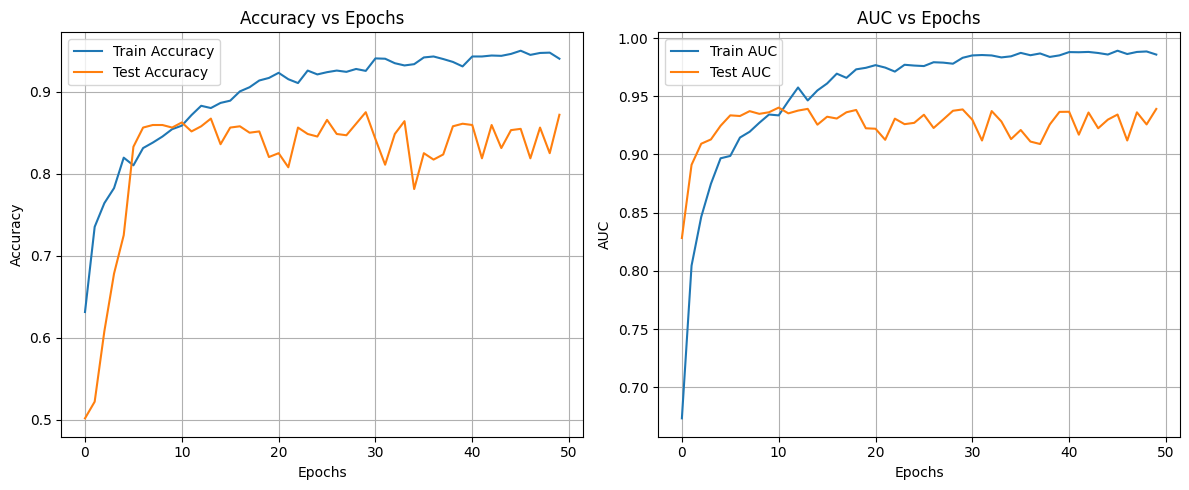

In [2]:
import os
import numpy as np
import tensorflow as tf
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

# Enable GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Error enabling GPU memory growth:", e)

# Paths
base_dir = os.path.join('dataset', 'lfw-deepfunneled', 'lfw-deepfunneled')
pairs_train_path = 'pairsDevTrain.txt'
pairs_test_path = 'pairsDevTest.txt'

def normalize_name(name):
    return name.replace(' ', '_')

def load_pairs(pairs_path, base_dir):
    pairs = []
    with open(pairs_path, 'r') as f:
        for line in f.readlines()[1:]:
            parts = line.strip().split()
            if len(parts) == 3:  # Positive pair
                person, img1, img2 = parts
                person = normalize_name(person)
                img1_path = os.path.join(base_dir, person, f"{person}_{int(img1):04d}.jpg")
                img2_path = os.path.join(base_dir, person, f"{person}_{int(img2):04d}.jpg")
                if os.path.exists(img1_path) and os.path.exists(img2_path):
                    pairs.append((img1_path, img2_path, 1))
            elif len(parts) == 4:  # Negative pair
                person1, img1, person2, img2 = parts
                person1, person2 = normalize_name(person1), normalize_name(person2)
                img1_path = os.path.join(base_dir, person1, f"{person1}_{int(img1):04d}.jpg")
                img2_path = os.path.join(base_dir, person2, f"{person2}_{int(img2):04d}.jpg")
                if os.path.exists(img1_path) and os.path.exists(img2_path):
                    pairs.append((img1_path, img2_path, 0))
    return pairs

# Load pairs
train_pairs = load_pairs(pairs_train_path, base_dir)
test_pairs = load_pairs(pairs_test_path, base_dir)
all_pairs = train_pairs + test_pairs

# Load SENet backbone from VGGFace2
image_input = Input(shape=(224, 224, 3))
senet_model = VGGFace(model='senet50', input_tensor=image_input, include_top=False, pooling='avg')

def preprocess_image(img_path, augment=False):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = preprocess_input(img_array, version=2)
    return img_array

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        pt = tf.exp(-bce)
        return alpha * (1 - pt) ** gamma * bce
    return loss

classification_input = Input(shape=(2048,))
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(classification_input)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
classification_output = Dense(1, activation='sigmoid')(x)

classification_model = Model(inputs=classification_input, outputs=classification_output)
classification_model.compile(optimizer=Adam(learning_rate=1e-4),
                             loss=focal_loss(),
                             metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

def generate_embedding_data(pairs, model):
    data = []
    labels = []
    for img1_path, img2_path, label in pairs:
        try:
            img1 = preprocess_image(img1_path)
            img2 = preprocess_image(img2_path)
            emb1 = model.predict(np.expand_dims(img1, axis=0), verbose=0)[0]
            emb2 = model.predict(np.expand_dims(img2, axis=0), verbose=0)[0]
            emb1 = normalize(emb1.reshape(1, -1))[0]
            emb2 = normalize(emb2.reshape(1, -1))[0]
            data.append(np.abs(emb1 - emb2))
            labels.append(label)
        except Exception as e:
            print(f"Error processing pair: {img1_path}, {img2_path}: {e}")
    return np.array(data), np.array(labels)

# Generate data
X, y = generate_embedding_data(all_pairs, senet_model)

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Learning rate scheduler
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 30:
        return lr * 0.5
    else:
        return lr * 0.1

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_auc', patience=15, restore_best_weights=True, verbose=1),
    LearningRateScheduler(lr_schedule)
]

# Train the model
history = classification_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# Evaluate on training set
y_train_probs = classification_model.predict(X_train, verbose=0)
y_train_pred = (y_train_probs > 0.5).astype(int)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_probs)

# Evaluate on testing set
y_test_probs = classification_model.predict(X_test, verbose=0)
y_test_pred = (y_test_probs > 0.5).astype(int)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_probs)

# Print results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training AUC: {train_auc * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")
print(f"Testing AUC: {test_auc * 100:.2f}%")

# Plot accuracies and AUC
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# AUC plot
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Test AUC')
plt.title('AUC vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
